In [7]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [8]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots

In [9]:
seed = 2
rng = MersenneTwister(seed)

T = 10
N = 50
gg = uniform_tree(N; rng)
g = IndexedBiDiGraph(gg)

β = 1.0
h = 0.15
m⁰ = 0.7
K = 30
σ = 1/60
;

In [10]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

In [11]:
J = zeros(nv(g),nv(g))
for i in axes(J)[1], j in axes(J)[2]
    j>i && continue
    if has_edge(gg,i,j)
        J[i,j] = 2*rand(rng)-1
        J[j,i] = J[i,j]
    end
end

J

50×50 Matrix{Float64}:
 0.0       0.0  0.0  0.0  0.0       …   0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.583057  …   0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0          -0.251194  0.0  0.0  0.224523
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 ⋮                                  ⋱                       
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0           0.0       0.0  0.0  0.0
 0.743591  0.0 

In [12]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

w_fourier = [fill(GlauberFactor([J[ed.src,ed.dst] for ed in inedges(g,i)], h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [13]:
matrix_sizes = [5, 10, 15]
maxiters = [5, 5, 0]
iters = zeros(Int, length(maxiters))
tol = 1e-16

for i in eachindex(maxiters)
    iters[i], _ = iterate_fourier!(bp_fourier, K; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), σ, tol)
end

Running MPBP: iter 2    Time: 0:00:52

Running MPBP: iter 3    Time: 0:01:04

Running MPBP: iter 4    Time: 0:01:16

Running MPBP: iter 2    Time: 0:03:31

Running MPBP: iter 3    Time: 0:05:41

Running MPBP: iter 4    Time: 0:07:51

Running MPBP: iter 5    Time: 0:10:01

In [14]:
nsamples = 10^6
sms = SoftMarginSampler(bp_fourier)
sample!(sms, nsamples)
;

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:34


In [18]:
m_fourier = real.(means(potts2spin, bp_fourier))
traj_mc = [[vec(potts2spin.(X[i,:])) for X in sms.X] for i in 1:N]
m_mc = [mean(x) for x in traj_mc]
σ_mc = [std(x)/sqrt(nsamples) for x in traj_mc]
;

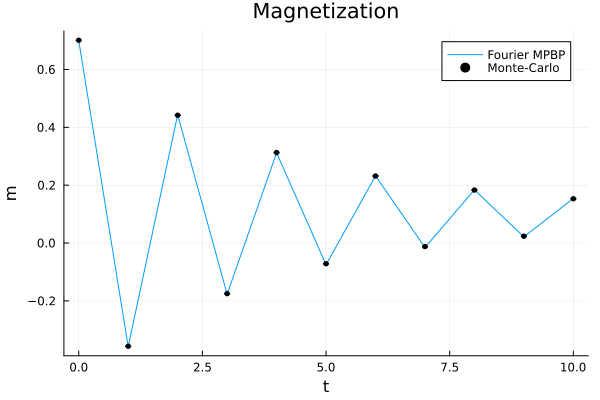

In [78]:
i = 50
y_mc = m_mc[i]
y_fourier = m_fourier[i]

pl = plot(xlabel="t", ylabel="m", title="Magnetization", legend=:topright)
plot!(pl, 0:T, y_fourier[1:end], label="Fourier MPBP")
plot!(pl, 0:T, y_mc[1:end], yerr=σ_mc[i], c=:black, st=:scatter, marker=:dot, markersize=3, label="Monte-Carlo")
display(pl)

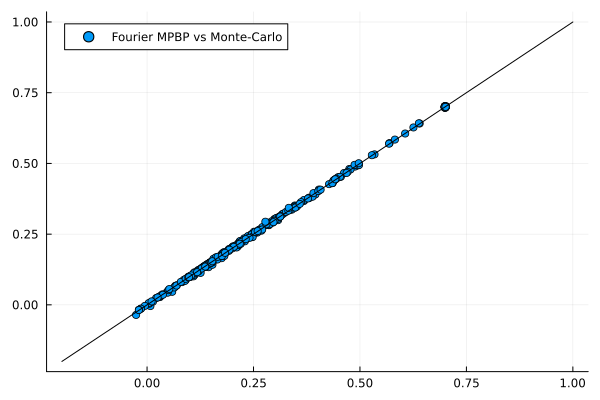

In [28]:
y_fourier_sc = reduce(vcat, y[1:2:end] for y in m_fourier)
y_mc_sc = reduce(vcat, y[1:2:end] for y in m_mc)
pl2 = plot()
plot!(pl2, y_mc_sc, y_fourier_sc, st=:scatter, label="Fourier MPBP vs Monte-Carlo")
plot!(pl2, -0.2:0.1:1, -0.2:0.1:1, c=:black, label="")